In [23]:
#!/usr/bin/env python
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [24]:
'''
    Testing flood for HTTP (aport=80,443) - 443 for SSL - doesn't make that great of a difference so we keep it
'''
p = subprocess.run("rwfilter ./mysterious-dataset.rw --aport=80,443 --pass=stdout  --type=all | rwuniq --fields=sTime --sort-output --flows --no-columns --column-separator=' ' --no-title",
                    capture_output=True,
                    shell=True
                )

# I have had some problems using (rwfilter with SILK_DATA_ROOTDIR even with right silk.conf configurations) 
# the start-date and end-date filtering, problems which I don't know where they come from or how to solve.

# --start-date=2014/11/24:16 --end-date=2014/11/24:17
# --start-date=2014/11/24:16 --end-date=2014/12/01:13

if p.stderr:
    raise p.stderr.decode()

out = p.stdout.decode()

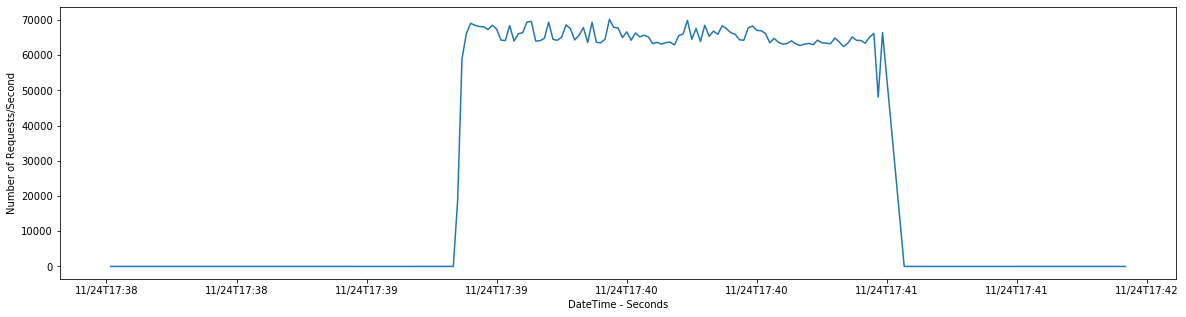

In [25]:
# key = x = dates
# values = y = count
dates_in_seconds = dict()
t = out.splitlines()
for l in t:
    date_time,count = l.strip().split(' ')
    dt = datetime.strptime(date_time, '%Y/%m/%dT%H:%M:%S')
    
    if datetime.strptime('2014/11/24T17:38:00', '%Y/%m/%dT%H:%M:%S') < dt < datetime.strptime('2014/11/24T17:42:00', '%Y/%m/%dT%H:%M:%S'):
        dates_in_seconds[dt] = int(count)


# seconds
lx = list(dates_in_seconds.keys())
y = list(dates_in_seconds.values())
x = pd.to_datetime(lx)


fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,1,1)

ax.plot(x.to_pydatetime(), y)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%dT%H:%M'))

ax.set_xlabel("DateTime - Seconds")
ax.set_ylabel("Number of Requests/Second")

plt.show()

The requests are usually around 2-13, but there seems to be a peak between 17h39 and 17h41. This being the HTTP port, it could be a false alarm, so we should check from which ip addresses these requests come from.

In [26]:
# With the sudden peak of requests not justified that is shown in the graph, we now know that there was an attack between 5h39PM-5h40PM
# Now we find out where the attack comes from, and to where it was directed

p = subprocess.run("rwfilter ./mysterious-dataset.rw --aport=80 --flags-all=S/S --pass=stdout  --type=all | rwuniq --fields=sTime,sip,dip --sort-output --flows --no-columns --column-separator=' ' --no-title",
                    capture_output=True,
                    shell=True
                )

if p.stderr:
    raise p.stderr.decode()

requests = dict()
for l in p.stdout.decode().splitlines():
    start_time, source_ip, destination_ip, count = l.strip().split(' ')
    count = int(count)
    dt = datetime.strptime(start_time, '%Y/%m/%dT%H:%M:%S')
    if datetime.strptime('2014/11/24T17:38:00', '%Y/%m/%dT%H:%M:%S') < dt < datetime.strptime('2014/11/24T17:42:00', '%Y/%m/%dT%H:%M:%S'):
        key: str = "src:'{}'/dest:'{}'".format(source_ip, destination_ip)
        if requests.get(key):
            requests[key] += count
        else:
            requests[key] = count

requests

{"src:'192.168.0.39'/dest:'192.168.0.200'": 76,
 "src:'192.168.0.64'/dest:'192.168.0.200'": 69,
 "src:'192.168.0.200'/dest:'192.168.0.39'": 76,
 "src:'192.168.0.200'/dest:'192.168.0.64'": 69,
 "src:'192.168.0.94'/dest:'192.168.0.200'": 72,
 "src:'192.168.0.200'/dest:'192.168.0.94'": 72,
 "src:'192.168.0.113'/dest:'192.168.0.200'": 1299095,
 "src:'192.168.0.200'/dest:'192.168.0.113'": 1288014}

These requests go back and forth between 192.168.0.113 and 192.168.9.299, and it seems that the address 192.168.0.200 might be an internal server, so it is safe to assume that there was an HTTP Flood from the address 192.168.0.113.